In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import torchmetrics
from torchmetrics import Accuracy
import matplotlib.pyplot as plt

c:\Users\emirh\anaconda3\envs\tlib\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Getting a dataset
train_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor(), target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)


In [3]:
# First training sample
image, label = train_data[0]
image.shape


torch.Size([1, 28, 28])

In [4]:
# How many samples are there?
print(
    f"""---- TRAIN DATA ----
Length of features: {len(train_data.data)} \nLength of target: {len(train_data.targets)}
---- TEST DATA ----
Length of features: {len(test_data.data)} \nLength of target: {len(test_data.targets)}"""
)


---- TRAIN DATA ----
Length of features: 60000 
Length of target: 60000
---- TEST DATA ----
Length of features: 10000 
Length of target: 10000


In [5]:
# Classes name
class_name = train_data.classes
class_name  # There are 10 different classes, it means our problem is multi-class classification.


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

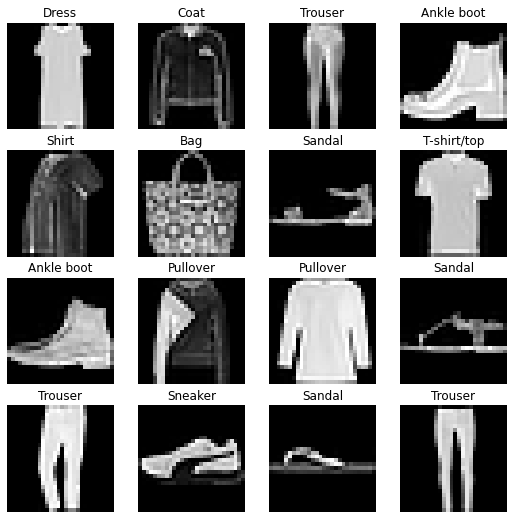

In [6]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    rnd_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rnd_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_name[label])
    plt.axis(False)


In [7]:
# DataLoader: Combines a dataset and a sampler, and provides an iterable over the given dataset
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


In [8]:
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [9]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))


In [10]:
train_features_batch.shape, train_labels_batch.shape
# [batch_size,color,height,width]

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"


### Building Baseline Model

In [12]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )

    def forward(self, x):
        return self.layer(x)


model_0 = FashionMNISTModelV0(
    input_shape=784, output_shape=len(train_data.classes), hidden_units=10
)
model_0.to(device)


FashionMNISTModelV0(
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [13]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(train_data.classes)).to(device)


In [14]:
torch.manual_seed(42)
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model_0.train()
        # forward pass
        y_pred = model_0(X)
        # Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        # Calculate accuracy (per batch)
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        # Optimizer zero grad
        optimizer.zero_grad()
        # Backward pro
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    # Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(
        f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}% \nTest loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}% "
    )


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------


 33%|███▎      | 1/3 [00:23<00:47, 23.56s/it]

Train loss: 0.59128 | Train accuracy: 0.79% 
Test loss: 0.50185 | Test accuracy: 0.82% 
Epoch: 1
-------


 67%|██████▋   | 2/3 [00:41<00:20, 20.16s/it]

Train loss: 0.47731 | Train accuracy: 0.83% 
Test loss: 0.48444 | Test accuracy: 0.83% 
Epoch: 2
-------


100%|██████████| 3/3 [00:58<00:00, 19.63s/it]

Train loss: 0.45565 | Train accuracy: 0.84% 
Test loss: 0.47966 | Test accuracy: 0.83% 


### Evaluate model prediction

In [39]:
def eval_model(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn,
    device: torch.device = device,
):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,  # only works when model was created with a class
        "model_loss": np.round(loss.item(), 4),
        "model_acc": f"{np.round(acc.item(),4)*100}%",
    }


In [40]:
model_0_results = eval_model(
    model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4797,
 'model_acc': '83.44%'}

### Improving Baseline Model

In [17]:
# Adding relu layer for non-linearity
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor):
        return self.layer(x)


In [18]:
model_1 = FashionMNISTModelV1(
    input_shape=784, hidden_units=10, output_shape=len(train_data.classes)
).to(device)


In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(train_data.classes)).to(
    device
)


### Functionizing training and test loops

In [20]:
def train_step_fn(
    model: nn.Module,
    data_loader: torch.utils.data.dataset,
    loss_fn: nn.Module,
    accuracy_fn: torchmetrics,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device,
):

    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"train loss: {train_loss:.4f} | train acc: {train_acc:.2f}%")


In [21]:
def test_step_fn(model: nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: nn.Module,
                accuracy_fn:torchmetrics,
                device: torch.device=device):
                
    test_loss,test_acc=0,0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred,y)
            test_acc += accuracy_fn(y,y_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"test loss: {test_loss:.4f} | test acc: {test_acc:.2f}%\n")
     

In [22]:
torch.manual_seed(42)
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}\n---------")
    train_step_fn(
        model=model_1,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        optimizer=optimizer,
        device=device,
    )
    test_step_fn(
        model=model_1,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
    )


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
---------
train loss: 0.9289 | train acc: 0.70%


 33%|███▎      | 1/3 [00:18<00:37, 18.59s/it]

test loss: 0.5421 | test acc: 0.81%

Epoch: 2
---------
train loss: 0.4988 | train acc: 0.82%


 67%|██████▋   | 2/3 [00:35<00:17, 17.86s/it]

test loss: 0.5037 | test acc: 0.82%

Epoch: 3
---------
train loss: 0.4625 | train acc: 0.83%


100%|██████████| 3/3 [00:53<00:00, 17.79s/it]

test loss: 0.4854 | test acc: 0.83%



In [41]:
model_1_result = eval_model(
    model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device,
)


In [42]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4797,
 'model_acc': '83.44%'}

In [43]:
model_1_result

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.4854,
 'model_acc': '83.05%'}

### Building a Convolutional Neural Network (CNN)

In [31]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape),
        )

    def forward(self, x):
        x = self.block_1(x)
        #print(f"Shape of block_1: {x.shape}")
        x = self.block_2(x)
        #print(f"Shape of block_2: {x.shape}")
        x = self.classifier(x)
        return x


torch.manual_seed(42)
model_2 = FashionMNISTModelV2(
    input_shape=1, hidden_units=10, output_shape=len(class_name)
).to(device)
model_2


FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [32]:
torch.manual_seed(42)
# Create a random tensor with a similiar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 28, 28))
print(f"Random tensor shape: {random_tensor.shape}")

Random tensor shape: torch.Size([1, 1, 28, 28])


In [33]:
# Testing shape error
model_2(random_tensor.to(device))
# Shape of block_1: torch.Size([1, 10, 14, 14])
# Shape of block_2: torch.Size([1, 10, 7, 7])
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x490 and 10x10)
# ---
# SOLUTION: We need to multiply shape of block_2 for last layer (classifier) -->[1, 10, 7, 7]--> batch * hidden_units * input_Shape * output_shape = 490

tensor([[ 0.0505, -0.0729,  0.0821, -0.0451, -0.0044,  0.0383,  0.0061, -0.0016,
         -0.0127, -0.0081]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [36]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_name)).to(device)


In [38]:
torch.manual_seed(42)
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")
    train_step_fn(model_2, train_dataloader, loss_fn, accuracy_fn, optimizer, device)
    test_step_fn(model_2, test_dataloader, loss_fn, accuracy_fn, device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
train loss: 0.3591 | train acc: 0.87%


 33%|███▎      | 1/3 [00:36<01:13, 36.63s/it]

test loss: 0.3490 | test acc: 0.87%

Epoch: 1
--------
train loss: 0.3203 | train acc: 0.88%


 67%|██████▋   | 2/3 [01:12<00:36, 36.42s/it]

test loss: 0.3304 | test acc: 0.88%

Epoch: 2
--------
train loss: 0.2996 | train acc: 0.89%


100%|██████████| 3/3 [01:49<00:00, 36.38s/it]

test loss: 0.3123 | test acc: 0.89%



In [45]:
model_2_result = eval_model(model_2,test_dataloader,loss_fn,accuracy_fn,device)

#### Compare Model Results

We've trained three different models.

- model_0 - our baseline model with two nn.Linear() layers.

- model_1 - the same setup as our baseline model except with nn.ReLU() layers in between the nn.Linear() layers.

- model_2 - our first CNN model that mimics the TinyVGG architecture on the CNN Explainer website.

In [46]:
compare_results = pd.DataFrame([model_0_results, model_1_result, model_2_result])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.4797,83.44%
1,FashionMNISTModelV1,0.4854,83.05%
2,FashionMNISTModelV2,0.3123,88.79%


#### Make Random Predictions

In [63]:
import random

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}")
print(f"Test label: {test_labels[0]} ({class_name[test_labels[0]]})")


Test sample image shape: torch.Size([1, 28, 28])
Test label: 6 (Shirt)


In [112]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_labels = []
    model.eval()
    with torch.inference_mode():
        for sample in data:

            sample = torch.unsqueeze(sample, dim=1).to(device)

            pred_logit = model(sample)

            pred_label = torch.softmax(pred_logit.squeeze(), dim=0).argmax(dim=0)

            pred_labels.append(pred_label.cpu())  # matplotlib work on cpu

    # # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_labels)


In [116]:
pred_classes= make_predictions(model=model_2, 
                             data=test_samples)


In [117]:
pred_classes

tensor([0, 7, 2, 9, 6, 4, 9, 6, 5])

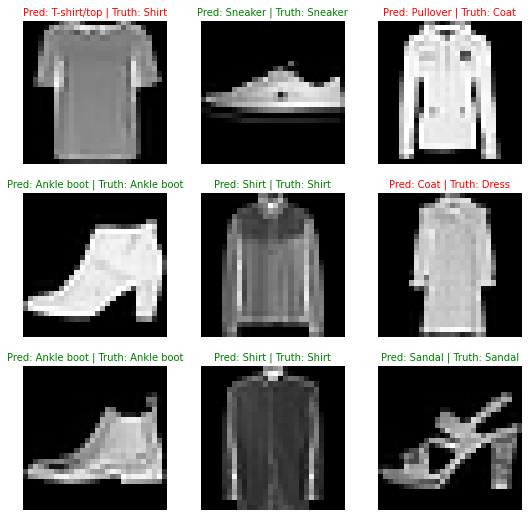

In [118]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_name[pred_classes[i]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_name[test_labels[i]]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")  # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r")  # red text if wrong
    plt.axis(False)


#### Make a Confusion Matrix

In [119]:
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)


Making predictions: 100%|██████████| 313/313 [00:02<00:00, 108.23it/s]


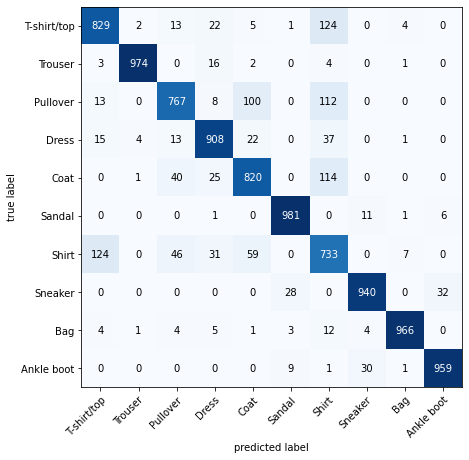

In [120]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

c_matrix = ConfusionMatrix(task="multiclass", num_classes=len(class_name))
cmat_tensor = c_matrix(preds=y_pred_tensor, target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=cmat_tensor.numpy(),  # matplotlib likes working with NumPy
    class_names=class_name,  # turn the row and column labels into class names
    figsize=(10, 7),
)


### Save Model

In [ ]:
from pathlib import Path

# MODEL_PATH= Path("model")
# MODEL_PATH.mkdir(parents=True,exist_ok=True)
# MODEL_NAME = "cnn_model_2.pth"
# MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
# # Save the model state dict
# torch.save(obj=model_2.state_dict(),f=MODEL_SAVE_PATH)